# KPI (Key Performance Indicator) 핵심 성과 지표

### 메트릭 Metric (측정 가능한 모든 수치)
- 방문자수, 클릭수, 매출액, 재고량
- 단순한 측정 값
### 지표 Indicator (의미가 부여된 메트릭)
- 전월 대비 방문자 증가율, 클릭 전환률, 매출 성장률
- 비교 기준이 있고, 변화와 방향성을 보여준다
### KPI (비즈니스 목표와 직결된 핵심 지표)
- CAC(고객 획득 비용), LTV/CLV(고객 생애 가치), NPS(순 고객 추천 지수)
- 전략적 의사결정에 직접 영향, 액션 가능한 인사이트 제공한다



In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings

warnings.filterwarnings('ignore', category=UserWarning)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
# 실습용 전자상거래 데이터 생성
np.random.seed(42)

# 고객 데이터 생성
customers = pd.DataFrame({
    'customer_id': range(1, 1001),
    'first_purchase_date': pd.date_range('2022-01-01', periods=1000, freq='D'),
    'acquisition_channel': np.random.choice(['organic', 'paid_search', 'social', 'email'], 1000, 
                                          p=[0.4, 0.3, 0.2, 0.1])
})

# 거래 데이터 생성 (더 현실적인 패턴)
transactions = []
for customer_id in range(1, 1001):
    first_date = customers[customers['customer_id'] == customer_id]['first_purchase_date'].iloc[0]
    
    # 고객별로 다른 구매 패턴 시뮬레이션
    purchase_frequency = np.random.exponential(30)  # 평균 30일마다 구매
    num_purchases = np.random.poisson(3) + 1  # 평균 3회 구매
    
    for i in range(num_purchases):
        purchase_date = first_date + timedelta(days=int(i * purchase_frequency))
        if purchase_date <= datetime(2024, 12, 31):
            transactions.append({
                'customer_id': customer_id,
                'purchase_date': purchase_date,
                'order_value': np.random.lognormal(4, 0.8),  # 로그정규분포로 현실적인 주문금액
                'order_id': len(transactions) + 1
            })

df = pd.DataFrame(transactions)
df['purchase_date'] = pd.to_datetime(df['purchase_date'])

print("데이터셋 개요")
print(f"총 고객 수: {len(customers):,}명")
print(f"총 거래 수: {len(df):,}건")
print(f"기간: {df['purchase_date'].min().date()} ~ {df['purchase_date'].max().date()}")

df.head(10)

데이터셋 개요
총 고객 수: 1,000명
총 거래 수: 3,871건
기간: 2022-01-01 ~ 2024-12-28


,customer_id,purchase_date,order_value,order_id
0,1,2022-01-01,16.099022,1
1,1,2022-01-07,52.126636,2
2,1,2022-01-13,105.086917,3
3,1,2022-01-19,60.768899,4
4,1,2022-01-25,78.047045,5
5,1,2022-01-31,46.034085,6
6,1,2022-02-06,134.727679,7
7,1,2022-02-12,51.196306,8
8,2,2022-01-02,17.740889,9
9,2,2022-02-26,81.518230,10


## RFM 분석
고객을 3가지 측면에서 바라보는 프리즘
- Recency: 얼마나 최근에 구매했는가? (최근성)
- Frequency: 얼마나 자주? (반복성, 충성도)
- Monetary: 얼마나 많이? (가치)

In [2]:
def calculate_rfm(t_df:pd.DataFrame, analysis_date='2024-12-31'):
    """
    RFM 분석 함수
    Recency: 활성도 측정. 낮을수록 좋음.
    Frequency: 충성도 측정. 높을수록 좋음.
    Monetary: 가치 측정. 높을수록 좋음
    """
    analysis_date = pd.to_datetime(analysis_date)
    rfm = t_df.groupby('customer_id').agg({
        # 활성도
        'purchase_date': lambda x: (analysis_date - x.max()).days,
        # 충성도
        'order_id': 'count',
        #가치
        'order_value': 'sum',
    }).reset_index()
    rfm.columns = ['customer_id', 'recency', 'frequency', 'monetary']
    # RFM 점수 계산
    rfm['r_score'] = pd.qcut(rfm['recency'], 5, labels=[5, 4, 3, 2, 1])
    rfm['f_score'] = pd.qcut(rfm['frequency'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5])
    rfm['m_score'] = pd.qcut(rfm['monetary'], 5, labels=[1, 2, 3, 4, 5])

    rfm['rfm_score'] = rfm['r_score'].astype(str) + rfm['f_score'].astype(str) + rfm['m_score'].astype(str)
    return rfm

rfm_data = calculate_rfm(df)
rfm_data


# 고객 세그먼트 정의

def segment_customers(rfm_data:pd.DataFrame):
    """
    RFM 점수를 기반으로 고객을 의미이쓴 세그먼트로 분류
    - R >= 4, F >= 4: 최고 고객
    - R >= 3, F >= 3: 충성 고객
    - R >= 4, F <= 2: 신규 고객
    - R <= 2, F <= 2: 이탈 고객
    """
def segment_customers(rfm_data: pd.DataFrame):
    """
    RFM 점수를 기반으로 고객을 의미있는 세그먼트로 분류
    - R >= 4, F >= 4: 최고
    - R >= 3, F >= 3: 충성
    - R >= 4, F <= 2: 신규
    - R <= 2, F >= 3: 위험
    - R <= 2, F <= 2: 이탈
    - 기타
    """
    def rfm_level(df):
        if (df['r_score'] >= 4) and (df['f_score'] >= 4):
            return '최고'
        elif (df['r_score'] >= 3) and (df['f_score'] >= 3):
            return '충성'
        elif (df['r_score'] >= 4) and (df['f_score'] <= 2):
            return '신규'
        elif (df['r_score'] <= 2) and (df['f_score'] >= 3):
            return '위험'
        elif (df['r_score'] <= 2) and (df['f_score'] <= 2):
            return '이탈'
        else:
            return '기타'
    
    rfm_data['segment'] = rfm_data.apply(rfm_level, axis=1)
    return rfm_data

rfm_segmented = segment_customers(rfm_data)
rfm_segmented

,customer_id,recency,frequency,monetary,r_score,f_score,m_score,rfm_score,segment
0,1,1053,8,544.086589,1,5,5,155,위험
1,2,983,3,122.971850,1,1,1,111,이탈
2,3,1055,2,325.510131,1,1,4,114,이탈
3,4,1046,5,454.940546,1,4,5,145,위험
4,5,954,8,269.436813,1,5,3,153,위험
...,...,...,...,...,...,...,...,...,...
995,996,19,4,408.573012,5,4,4,544,최고
996,997,86,3,403.810587,5,3,4,534,충성
997,998,95,5,303.249620,5,5,3,553,최고
998,999,3,4,250.638024,5,4,3,543,최고


In [3]:
count_cus = rfm_segmented.groupby('segment').agg({
    'customer_id': 'count',
    'recency': 'mean', # 등급별 최종방문일로부터 지난날 평균
    'frequency': 'mean', # 방문회수 평균
    'monetary':'mean' #쓴 돈 평균
}).round(2)

count_cus.columns = ['고객수', '지난날평균', '회수평균', '돈평균']

count_cus

,고객수,지난날평균,회수평균,돈평균
segment,,,,
기타,87,512.67,2.40,163.01
신규,121,251.12,2.45,195.11
위험,208,811.88,5.03,383.14
이탈,192,837.06,2.36,181.27
최고,208,205.57,5.05,379.44
충성,184,391.96,4.44,345.49


In [4]:
segment_insights = {
    '최고': '💎 최고의 고객들. VIP 프로그램과 개인화된 서비스 제공',
    '충성': '🏆 충성도 높은 고객들. 추가 상품 추천과 리워드 프로그램',
    '신규': '🌱 신규 고객들. 온보딩 프로그램과 첫 구매 할인',
    '위험': '⚠️ 이탈 위험 고객들. 재활성화 캠페인과 특별 할인',
    '이탈': '😢 이탈한 고객들. 윈백 캠페인과 강력한 인센티브'
}

print("\n💡 세그먼트별 액션 플랜")
print("=" * 50)
for segment, insight in segment_insights.items():
    if segment in rfm_segmented['segment'].values:
        count = len(rfm_segmented[rfm_segmented['segment'] == segment])
        print(f"{segment} ({count}명): {insight}")


💡 세그먼트별 액션 플랜
최고 (208명): 💎 최고의 고객들. VIP 프로그램과 개인화된 서비스 제공
충성 (184명): 🏆 충성도 높은 고객들. 추가 상품 추천과 리워드 프로그램
신규 (121명): 🌱 신규 고객들. 온보딩 프로그램과 첫 구매 할인
위험 (208명): ⚠️ 이탈 위험 고객들. 재활성화 캠페인과 특별 할인
이탈 (192명): 😢 이탈한 고객들. 윈백 캠페인과 강력한 인센티브


In [5]:
# 고객 생애 가치 (Customer Lifetime Value)
# 한 명의 고객이 "전체 거래 기간 동안" 회사에 가져다주는 이익
def calculate_clv(t_df: pd.DataFrame):
    """
    고객 생애 가치(CLV) 계산
    CLV = (평균주문가치) * (연간구매빈도) * (고객생존기간)

    해석방법:
    - CLV > CAC(고객획득비용): 수익성 있는 고객
    - CLV / CAC 비율이 3:1 이상이면 좋은 비즈니스
    """

    # 1. 평균 주문 가치!! 사람당 평균적으로 구매한 금액
    avg_order_value = t_df.groupby('customer_id')['order_value'].mean()

    # 2. 연간 구매 빈도 (구매 주기)
    def get_annual_purchase(x):
        # 1회 초과 구매한 경우
        if len(x) > 1:
            # 1년에 몇번정도 사느냐
            return len(x) / ((x['purchase_date'].max() - x['purchase_date'].min()).days + 1) * 365
        else:
            return 1
        
    purchase_frequency = t_df.groupby('customer_id').apply(get_annual_purchase)


    # 3. 고객 생존 기간
    lifespan_days = t_df.groupby('customer_id').apply(
        lambda x: (x['purchase_date'].max() - x['purchase_date'].min()).days + 1
    )

    # clv 계산
    clv_data = pd.DataFrame({
        'customer_id': avg_order_value.index,
        'avg_order_value': avg_order_value.values,
        'purchase_frequency': purchase_frequency.values,
        'lifespan_days': lifespan_days,
    })

    clv_data['clv'] = clv_data['avg_order_value'] * clv_data['purchase_frequency'] * (clv_data['lifespan_days'] / 365)
    return clv_data


clv_df = calculate_clv(df)


C:\Users\agnes\AppData\Local\Temp\ipykernel_10068\186577121.py:25: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  purchase_frequency = t_df.groupby('customer_id').apply(get_annual_purchase)
C:\Users\agnes\AppData\Local\Temp\ipykernel_10068\186577121.py:29: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  lifespan_days = t_df.groupby('customer_id').apply(


In [6]:
# 상위 10 ??????????????????????????????????????????????????
threshold = clv_df['clv'].quantile(0.9)
top_10 = clv_df[clv_df['clv'] >= threshold]
print(top_10)

             customer_id  avg_order_value  purchase_frequency  lifespan_days  \
customer_id                                                                    
1                      1        68.010824           67.906977             43   
22                    22        97.603975            7.300000            300   
32                    32       211.655959            7.891892            185   
50                    50       132.648139           15.732759            116   
64                    64       157.293235           10.209790            143   
...                  ...              ...                 ...            ...   
961                  961       129.546416           20.277778             90   
966                  966       133.967282           26.545455             55   
967                  967        77.474050           20.772358            123   
972                  972       128.834711          265.454545             11   
990                  990       130.77228

평균 CLV: $ 290.89
중앙값 CLV: $ 264.77
상위 10% 고객 기준 CLV: $ 526.87


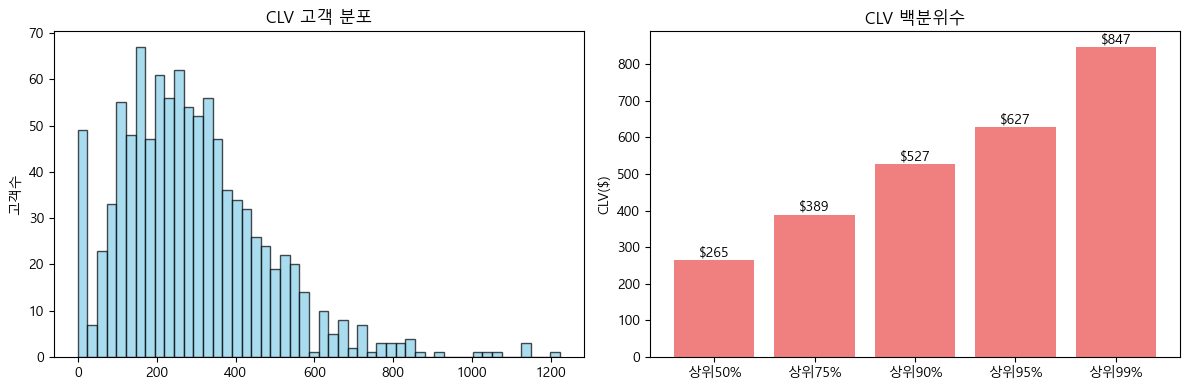

In [7]:
print(f'평균 CLV: $ {clv_df['clv'].mean():.2f}')
print(f'중앙값 CLV: $ {clv_df['clv'].median():.2f}')
print(f'상위 10% 고객 기준 CLV: $ {clv_df['clv'].quantile(0.9):.2f}')
print('=' * 50)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(clv_df['clv'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('CLV 고객 분포')
plt.ylabel('고객수')

plt.subplot(1, 2, 2)
clv_percentiles = [50, 75, 90, 95, 99]
clv_values = [clv_df['clv'].quantile(p/100) for p in clv_percentiles]

plt.bar(range(len(clv_percentiles)), clv_values, color='lightcoral')
plt.title('CLV 백분위수')
plt.ylabel('CLV ($)')
plt.xticks(range(len(clv_percentiles)), [f'상위{x}%' for x in clv_percentiles])
plt.ylabel('CLV($)')

# 막대그래프 위에 글씨 쓰기
for idx, value in enumerate(clv_values):
    # idx(x 좌표) 에, y좌표 막대 꼭대기 바로 위에 표시, 뭐라고 쓸지, 좌우정렬
    plt.text(idx, value + 10, f'${value:.0f}', ha='center')

plt.tight_layout()
plt.show()

In [9]:
# 파레토 법칙 검증 (20% 고객이 80% 매출을 만드나?)

# CLV 내림차순으로 정렬
clv_sorted = clv_df.sort_values('clv', ascending=False)
# 누적 CLV 컬럼 추가
clv_sorted['cum_clv'] = clv_sorted['clv'].cumsum()
# 해당 고객까지가 전체의 몇% 인지 컬럼 추가
clv_sorted['cum_clv_pct'] = clv_sorted['cum_clv'] / clv_sorted['clv'].sum() * 100
# 모든 고객 옆에 상위 몇% 인지 컬럼 추가
clv_sorted['customer_pct'] = (clv_sorted.index + 1) / len(clv_sorted) * 100

# CLV 정렬 기준 상위 20% 고객들만 보는 DF
upper_20p = clv_sorted[clv_sorted['customer_pct'] <= 20]

# 20% 고객까지의 누적 CLV
top20rev = upper_20p['cum_clv_pct'].iloc[-1]

print(f'파레토 분석 결과: 상위 20% 고객이 {top20rev:.2f}% 매출을 차지')

파레토 분석 결과: 상위 20% 고객이 100.00% 매출을 차지


## 코호트(Cohort) 분석
- 공통된 특성/경험을 가진 집단
- 특정 시점이나 조건을 기준으로 고객 집단을 추적
- 시간에 따라 행동 패턴의 변화를 분석

In [35]:
# 최초 첫 구매 월 기준으로 코호트 생성
t_cohort = df.copy()
t_cohort['purchase_period'] = t_cohort['purchase_date'].dt.to_period('M')

# 각 고객의 첫 구매 월
first_purchase = t_cohort.groupby('customer_id')['purchase_date'].min().dt.to_period('M')
first_purchase = first_purchase.reset_index()
first_purchase.columns = ['customer_id', 'cohort_group']

# 코호트 데이터 결합
t_cohort = t_cohort.merge(first_purchase, on='customer_id', how='inner')

from operator import attrgetter
# 기간 계산 (첫 구매 이후 몇개월째인지) -> 이상한 객체가 나왔기 땜시, 처리도 특이한 방법으로 진행
t_cohort['after_n'] = (t_cohort['purchase_period'] - t_cohort['cohort_group']).apply(attrgetter('n'))


cohort_data = t_cohort.groupby(['cohort_group', 'after_n'])['customer_id'].nunique().reset_index()
cohort_size = first_purchase.groupby('cohort_group')['customer_id'].nunique()

# 각 그룹(최초구매월)이 N개월이 지났을 때, 총 구매 횟수
cohort_table = cohort_data.pivot(index='cohort_group', columns='after_n', values='customer_id')

cohort_table.divide(cohort_size, axis=0)

after_n,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
cohort_group,,,,,,,,,,,,,,,,,,,
2022-01,1.0,0.516129,0.354839,0.354839,0.225806,0.032258,0.129032,0.032258,0.064516,0.032258,0.064516,NaN,0.032258,NaN,NaN,NaN,NaN,NaN,NaN
2022-02,1.0,0.714286,0.642857,0.500000,0.214286,0.107143,0.071429,0.035714,NaN,0.035714,NaN,0.035714,NaN,NaN,0.035714,NaN,NaN,NaN,NaN
2022-03,1.0,0.612903,0.290323,0.225806,0.161290,0.129032,0.032258,0.064516,NaN,0.032258,NaN,NaN,0.032258,NaN,0.032258,NaN,NaN,NaN,NaN
2022-04,1.0,0.466667,0.433333,0.200000,0.300000,0.033333,0.133333,0.033333,0.133333,NaN,0.033333,NaN,0.033333,0.033333,NaN,NaN,NaN,0.033333,NaN
2022-05,1.0,0.516129,0.419355,0.225806,0.129032,0.032258,0.032258,0.064516,0.064516,NaN,0.032258,NaN,0.064516,NaN,NaN,NaN,0.032258,NaN,NaN
2022-06,1.0,0.466667,0.400000,0.200000,0.166667,0.133333,0.033333,0.066667,0.033333,NaN,0.033333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-07,1.0,0.677419,0.451613,0.290323,0.161290,0.129032,0.161290,0.064516,0.064516,0.032258,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-08,1.0,0.451613,0.419355,0.193548,0.129032,0.161290,0.096774,0.096774,0.032258,0.096774,0.032258,0.032258,0.096774,NaN,0.032258,NaN,NaN,NaN,NaN
2022-09,1.0,0.466667,0.333333,0.433333,0.033333,0.033333,0.133333,0.066667,0.066667,0.066667,0.033333,NaN,NaN,NaN,0.033333,NaN,NaN,NaN,0.033333
